In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o

## Result Gathering

In [94]:
main_df = None
directory = "Effort_Estimation_Results_3E/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [95]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,61,61,NaN,2.000000,2,2,NaN,8,1.000000,15.00000
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,78,78,NaN,1.000000,1,1,NaN,346,0.225434,1.00000
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,322,322,0.000000,1.500000,1,2,0.707107,35,1.000000,1.00000
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,36,661,228.672586,7.833333,1,13,4.018895,194,0.185567,3.71134
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,8,203,63.592452,37.000000,1,136,50.585661,1938,0.004128,1.00000


In [96]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [97]:
len(main_df)

775

In [98]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='y_test')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='y_pred')
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

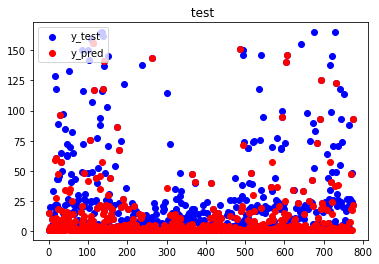

In [99]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],' test')

In [100]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [101]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



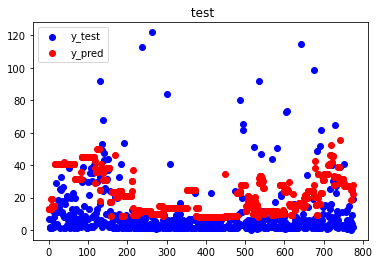

In [102]:
plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x21e16c48d30>,
 'caps': [<matplotlib.lines.Line2D at 0x21e16c54400>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e16c48be0>],
 'medians': [<matplotlib.lines.Line2D at 0x21e16c54b00>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e16c54e80>],
 'means': []}

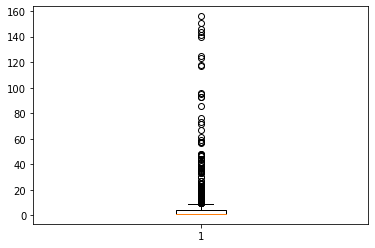

In [103]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [104]:
main_df = main_df[main_df['refactoring_perc_time_taken'] >= 2]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

{'whiskers': [<matplotlib.lines.Line2D at 0x21e16cb1e10>,
 'caps': [<matplotlib.lines.Line2D at 0x21e16cc04e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e16cb1cc0>],
 'medians': [<matplotlib.lines.Line2D at 0x21e16cc0b38>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e16cc0eb8>],
 'means': []}

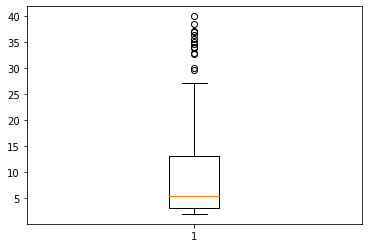

In [105]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [106]:
main_df['time_taken_final'].value_counts()

1.0     43
2.0     26
6.0     17
4.0     17
7.0     15
        ..
50.6     1
21.4     1
43.4     1
8.4      1
19.0     1
Name: time_taken_final, Length: 70, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x21e187437f0>,
 'caps': [<matplotlib.lines.Line2D at 0x21e18743e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e187436a0>],
 'medians': [<matplotlib.lines.Line2D at 0x21e1874d5c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e1874d940>],
 'means': []}

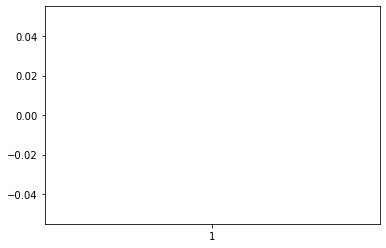

In [107]:
plt.boxplot(main_df['time_taken_final'])

In [108]:
main_df = main_df.fillna(0)

In [109]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,61,0.000000,2.000000,2,2,0.000000,8,1.000000,15.000000,7.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,661,228.672586,7.833333,1,13,4.018895,194,0.185567,3.711340,1.0
9,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,764,0.000000,9.000000,9,9,0.000000,202,1.000000,10.000000,6.0
11,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,115,0.000000,4.500000,3,6,2.121320,400,0.287500,9.487500,12.0
12,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,320,100.862943,4.000000,1,7,2.160247,14,1.000000,2.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,206,0.000000,17.000000,17,17,0.000000,714,0.288515,6.347339,1.0
42,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,411,132.213212,17.500000,3,32,16.743158,635,0.286614,7.738583,6.0
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,119,52.064863,2.000000,1,3,0.866025,16,0.750000,18.750000,5.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,388,0.000000,1.000000,1,1,0.000000,535,0.725234,17.405607,4.0


In [110]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [111]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [112]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [113]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [114]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [115]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [116]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.00000,85.000000,61.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.00000,57.583333,222.666667
9,38.000000,38.0,38.0,0.000000,57.000000,57.0,57.0,0.000000,1.000000,1.0,...,279.000000,279.0,279.0,0.000000,17.000000,17.0,17.0,0.00000,322.000000,764.000000
11,4.000000,4.0,4.0,0.000000,15.000000,15.0,15.0,0.000000,1.000000,1.0,...,108.000000,108.0,108.0,0.000000,1.000000,1.0,1.0,0.00000,371.000000,115.000000
12,15.142857,9.0,23.0,4.740906,9.714286,3.0,41.0,13.960830,1.714286,1.0,...,78.428571,39.0,162.0,51.980308,7.857143,1.0,17.0,8.55236,46.857143,103.000000


In [117]:
y.head()

,refactoring_perc_time_taken
0,15.00000
3,3.71134
9,10.00000
11,9.48750
12,2.00000


In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [119]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 mins 42 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,4 months and 2 days !!!
H2O_cluster_name:,H2O_from_python_tanji_54frkf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.931 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [120]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [121]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [122]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [123]:
aml = H2OAutoML(max_models=10, seed=16, exclude_algos=['XGBoost', 'GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████
00:08:34.147: Skipping training of model GBM_5_AutoML_20220105_000828 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20220105_000828.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 184.0.


█████████████████████████████████████████████████| 100%
Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpgjpv2zl1.csv'


In [124]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20220105_000828,71.2827,8.44291,71.2827,6.67639,0.789051
StackedEnsemble_BestOfFamily_AutoML_20220105_000828,72.0051,8.48558,72.0051,6.65256,0.785196
GBM_grid__1_AutoML_20220105_000828_model_1,80.0747,8.94844,80.0747,6.94295,0.823919
GBM_2_AutoML_20220105_000828,81.4221,9.02342,81.4221,6.97794,0.824469
XRT_1_AutoML_20220105_000828,84.4942,9.19207,84.4942,7.21101,0.851498
GBM_3_AutoML_20220105_000828,84.8603,9.21197,84.8603,7.11007,0.845913
GBM_4_AutoML_20220105_000828,86.9294,9.3236,86.9294,7.22943,0.862268
DRF_1_AutoML_20220105_000828,87.4001,9.3488,87.4001,7.51057,0.866305
GBM_1_AutoML_20220105_000828,94.6975,9.73126,94.6975,7.45856,0.883705
GBM_grid__1_AutoML_20220105_000828_model_2,95.3455,9.7645,95.3455,7.52184,0.872568


In [125]:
model = h2o.get_model(lb[0,'model_id'])

In [126]:
model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20220105_000828

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 58.47588956451796
RMSE: 7.646952959481179
MAE: 5.928092826418534
RMSLE: 0.7088820639964137
R^2: 0.16582070810095395
Mean Residual Deviance: 58.47588956451796
Null degrees of freedom: 183
Residual degrees of freedom: 181
Null deviance: 12898.382619132974
Residual deviance: 10759.563679871306
AIC: 1278.794452835286

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 71.28271662340953
RMSE: 8.442909251165117
MAE: 6.676387036135898
RMSLE: 0.7890514982264365
R^2: -0.01687321937957953
Mean Residual Deviance: 71.28271662340953
Null degrees of freedom: 183
Residual degrees of freedom: 182
Null deviance: 12941.923287730318
Residual deviance: 13116.019858707354
AIC: 1313.2336967957285


In [127]:
preds = model.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [128]:
preds

predict
8.54169
8.92152
8.58393
9.38689
9.50305
9.39518
10.0904
7.97508
8.5969
7.98573


In [129]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

9.261780    1
7.975080    1
9.289172    1
8.596900    1
9.351723    1
           ..
8.543211    1
3.701302    1
8.438204    1
9.513583    1
7.558836    1
Name: predict, Length: 79, dtype: int64

In [130]:
train

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
11,11,11,0,8,8,8,0,2,2,2,0,9,9,9,0,15,15,15,0,6,6,6,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,63,63,63,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,6,6,6,0,2,2,2,0,4,4,4,0,0,0,0,0,4,4,4,0,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,0,58,58,58,0,17,17,17,0,85,61,15
23.25,5,63,20.7808,20.6667,4,64,21.9931,2,1,3,0.852803,40.4167,3,111,41.3597,27.1667,0,106,39.3512,15,3,37,13.1978,0.166667,0,1,0.389249,13.1667,3,35,13.4221,0.25,0,1,0.452267,1.33333,0,4,1.96946,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0,1,0.389249,7.66667,2,21,7.30297,1.66667,0,6,2.14617,1.16667,0,5,1.94625,6.5,2,21,7.42845,0,0,0,0,0,0,0,0,4,0,13,4.82418,0,0,0,0,7.91667,0,36,13.2216,193.583,37,531,191.017,6.5,0,24,8.5227,1.08333,0,2,0.668558,0.333333,0,2,0.778499,2.58333,0,15,5.80687,0.666667,0,2,0.778499,10.5833,0,31,10.3963,11.5,0,72,24.0435,27.3333,3,82,29.4104,2,0,5,2.21565,26.25,2,81,28.848,1.58333,0,3,1.1645,0,0,0,0,0.333333,0,2,0.778499,4.33333,0,10,3.8455,121.333,37,320,98.919,1,1,1,0,57.5833,222.667,3.71134
38,38,38,0,57,57,57,0,1,1,1,0,81,81,81,0,0,0,0,0,45,45,45,0,1,1,1,0,42,42,42,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,1,1,1,0,0,0,0,0,12,

{'whiskers': [<matplotlib.lines.Line2D at 0x21e18d626d8>,
 'caps': [<matplotlib.lines.Line2D at 0x21e18d58eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e18d62860>],
 'medians': [<matplotlib.lines.Line2D at 0x21e18d586a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e18d50f60>],
 'means': []}

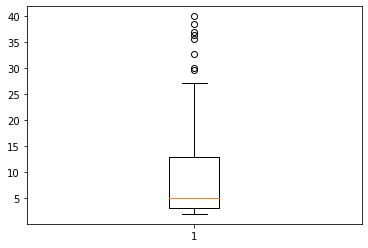

In [131]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

In [132]:
main_df['actual_num_of_classes_touched_max'].mean()

10.083650190114069

In [133]:
len(main_df['actual_num_of_classes_touched_max'])

263

In [134]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

263

In [135]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

261

In [136]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

254

In [137]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

226

In [138]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

184

{'whiskers': [<matplotlib.lines.Line2D at 0x21e18dca0b8>,
 'caps': [<matplotlib.lines.Line2D at 0x21e18dca780>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e18dbcf28>],
 'medians': [<matplotlib.lines.Line2D at 0x21e18dcae80>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e18dd4240>],
 'means': []}

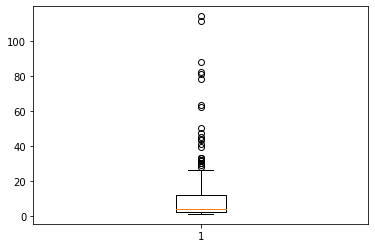

In [139]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [140]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x21e1739b240>,
 'caps': [<matplotlib.lines.Line2D at 0x21e1739b908>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e1739b0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x21e173a5048>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e173a53c8>],
 'means': []}

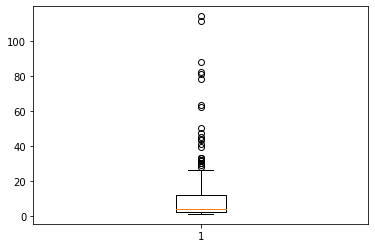

In [141]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x21e173e9d30>,
 'caps': [<matplotlib.lines.Line2D at 0x21e173fa438>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e173e9be0>],
 'medians': [<matplotlib.lines.Line2D at 0x21e173fab38>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e173faeb8>],
 'means': []}

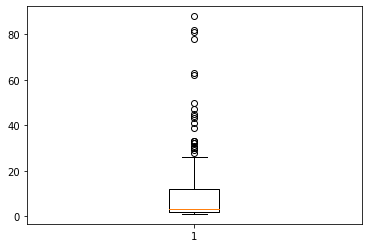

In [142]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [143]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [144]:
pd_preds

,predict,actual_time_taken
0,8.541695,7.411236
1,8.921524,11.963636
2,8.583927,33.817204
3,9.386891,3.000000
4,9.503050,15.519865
...,...,...
74,8.133967,37.152318
75,9.438173,4.263158
76,6.755371,3.582857
77,8.769024,17.405607


{'whiskers': [<matplotlib.lines.Line2D at 0x21e1744ba20>,
 'caps': [<matplotlib.lines.Line2D at 0x21e17457128>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e1744b8d0>],
 'medians': [<matplotlib.lines.Line2D at 0x21e17457828>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e17457ba8>],
 'means': []}

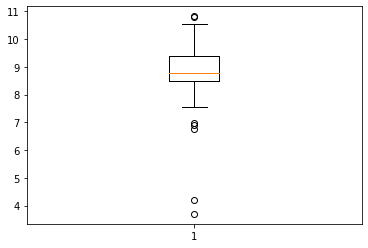

In [145]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x21e174aecc0>,
 'caps': [<matplotlib.lines.Line2D at 0x21e18e0e390>,
 'boxes': [<matplotlib.lines.Line2D at 0x21e174aeb70>],
 'medians': [<matplotlib.lines.Line2D at 0x21e18e0ea90>],
 'fliers': [<matplotlib.lines.Line2D at 0x21e18e0ee10>],
 'means': []}

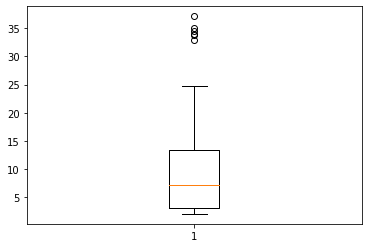

In [146]:
plt.boxplot(pd_preds['actual_time_taken'])

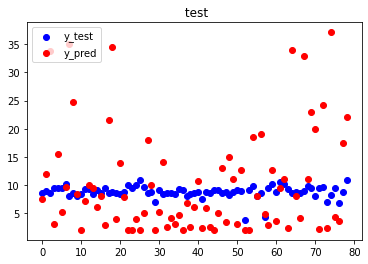

In [147]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],' test')

In [497]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

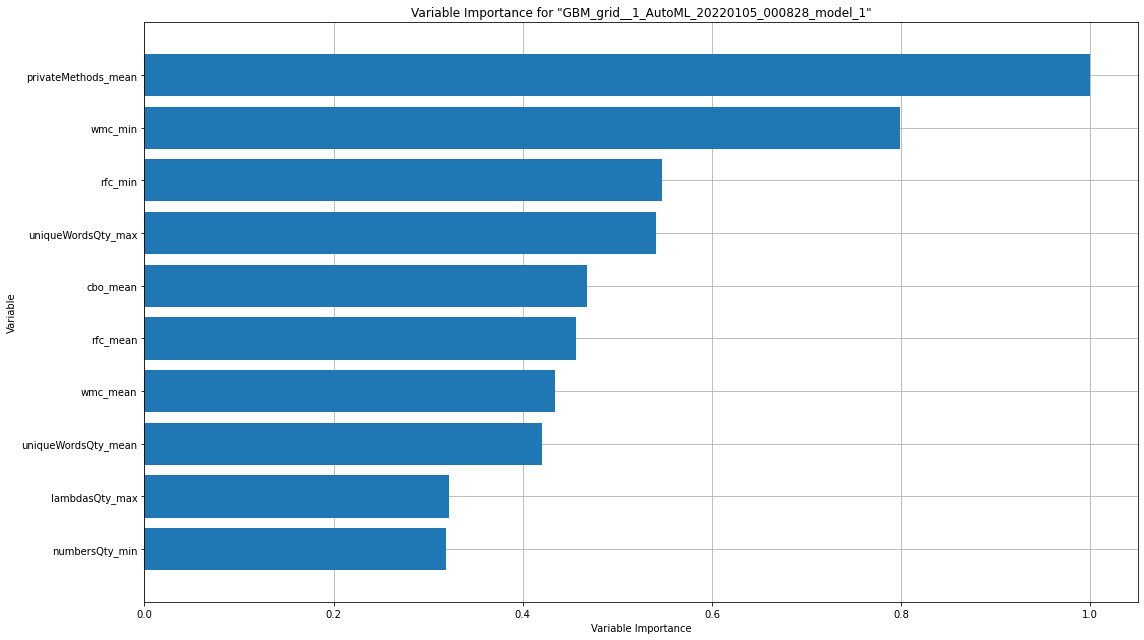

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

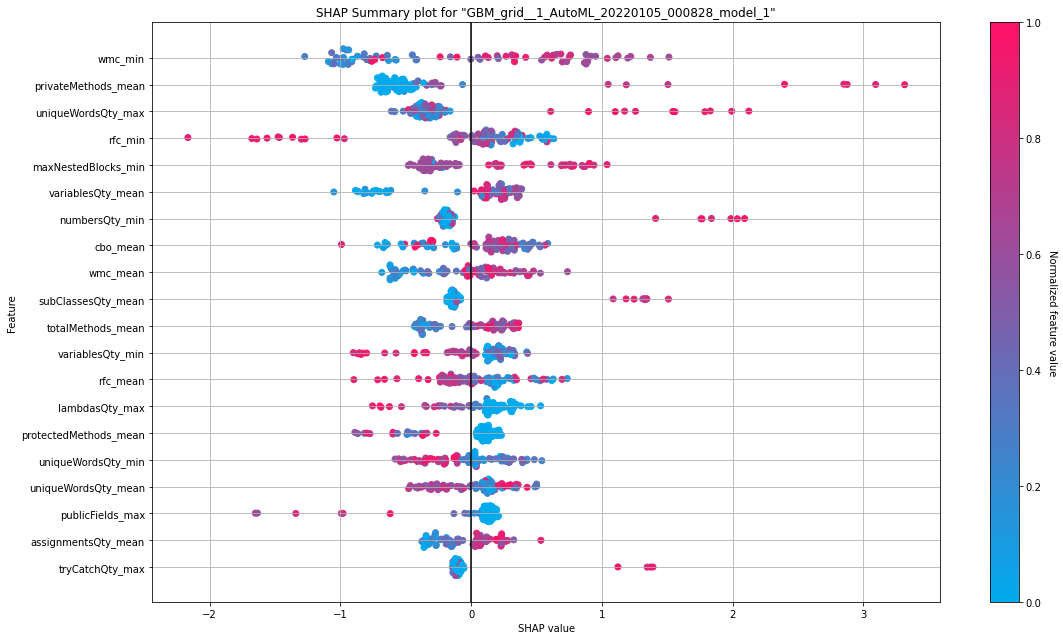

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

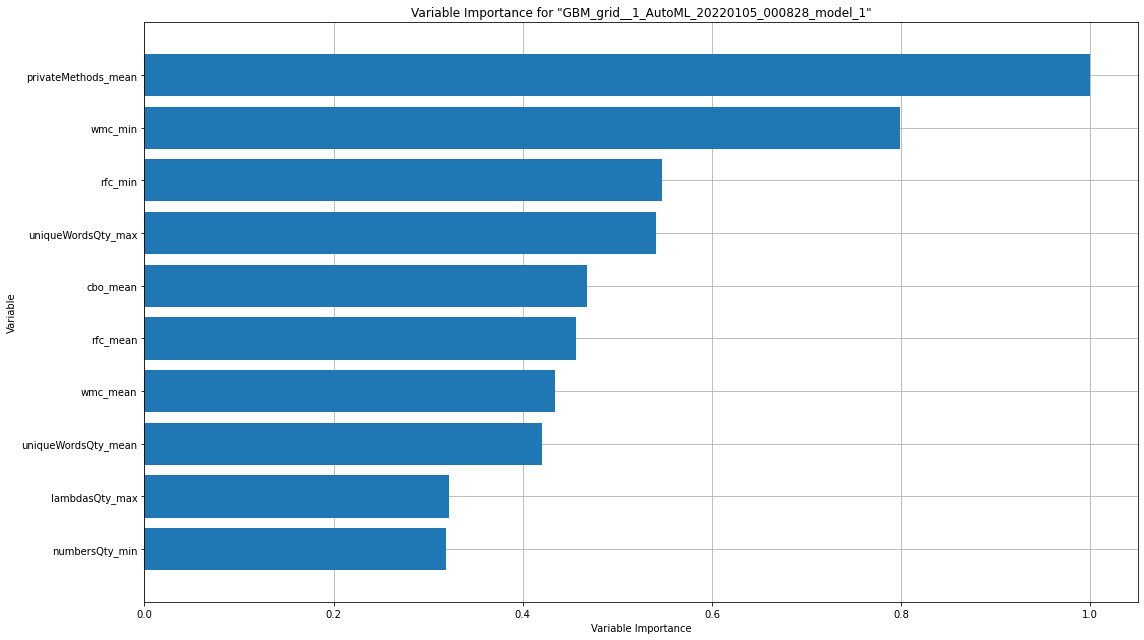

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

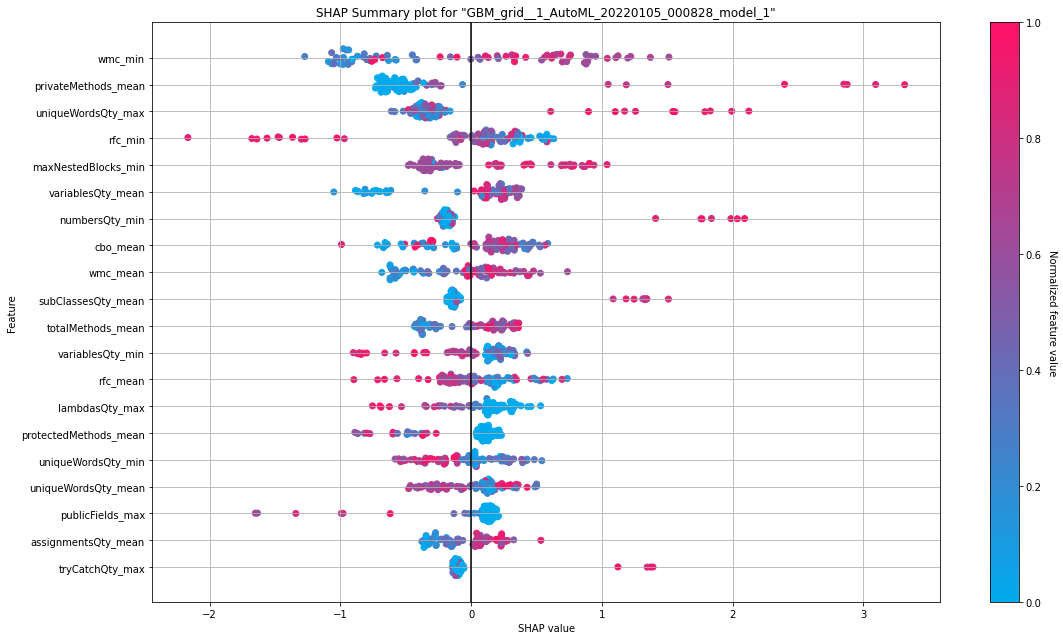

In [148]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [65]:
#aml.explain_row(test, row_index=0)

In [66]:
#h2o.shutdown()